# Common hurdles when working with GNNs.
---

## Tutorial Overview
In this tutorial will introduce you to two well-known problems that arise when working with Message Passing -based Graph Neural Networks (GNNs). Namely the practical difficulty of scaling to massive Graphs and the exponential compression of propagated information a.ka. Oversquashing.

## Outline

1. Task 1: Scaling GNNS over massive graphs via neighborhood subsampling.
2. Task 2: Deriving an upper bound on a quantitative measure of Oversquashing.

**NB**: Throughout the tutorial you'll find a couple of 📝 **TODO** items, which will prompt you to either fill in some code or write down the answer to a question.


## Setup.

Throughout this tutorial we will be using the following librairies.

* [Pytorch Geometric](https://): Pytorch-based library for developing GNNs.
* [Matplotlib](https://): Python's general purpose plotting library.  

The code cell below installs these libraries and define helper functions. You need not to care about these functions for now.

In [ ]:
# Install required packages.
import os
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
import matplotlib.pyplot as plt

2.4.0+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Task 1: Scaling GNNs over massive graphs via Neighborhood Subsampling



### Understanding the Scaling issue.
One of the challenges of Message Passing -based Graph Neural Networks is to scale them to large graphs. Indeed, because of the neighborhood aggregation operation, MP-based GNNs with $L$ layers have a naive worst-case (complete graph) memory complexity of $\Omega(BL|\mathcal{V}|)$ [(Blakely et al., 2019)](https://qdata.github.io/deep2Read//talks-mb2019/Derrick_201906_GCN_complexityAnalysis-writeup.pdf) per batch, where $B$ is the size of single batch of nodes. This makes them impractical to learn on large graphs.


### Neighborhood Subsampling: GraphSAGE
GraphSAGE  [(Hamilton et al., 2017)](https://arxiv.org/abs/1706.02216) is the most common node-wise sampling approach for training GNNs on large graphs. It works by uniformly sampling a certain number of neighbors at a given iteration and applying a GCN-like (aggregate and update) operation on the resulting subsampled neighborhood. GraphSAGE reduces the above complexity to $\Omega(BL\max_{k \leq L}S_k)  $, where $S_k$ is the number of neighbors sampled at the iteration/layer $k$.

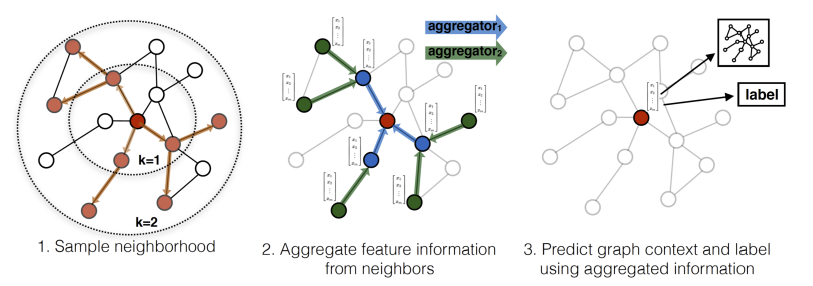

<em>Figure 1: Visual illustration of the GraphSAGE sample and aggregate approach. Source: [paper](https://arxiv.org/pdf/1706.02216)</em>

### Task description
In this task, you will train a GraphSAGE model on the PubMed dataset and analyze the impact of the neighborhood sample size $K$ on both the training performance and the memory footprint. The resulting plot will be similar to Figure 2B of the original paper.

### Overview of the PubMed dataset.

The PubMed dataset is a citation dataset containing papers from medical publications. It has ~10x more nodes and ~8x more edges than Cora.

In [ ]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/PubMed',  name='PubMed', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### Training the GraphSAGE model.

**📝TODO:** Fill in the code below that creates and trains a GraphSAGE model.

In [ ]:
import functools
import numpy as np
from torch_geometric.nn import GraphSAGE
from torch_geometric.loader import NeighborLoader
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
num_epochs = 50
learning_rate = 0.01
batch_size = 256
hidden_channels = 16

def make_loader(sample_sizes: list[int], batch_size: int):
  """Returns a data loader that performs neighbor sampling."""
  return NeighborLoader(
      data=data,
      num_neighbors=sample_sizes,
      batch_size=batch_size,
      input_nodes=data.train_mask,
  )

def make_model(hidden_channels: int, num_layers: int):
  """Returns a GraphSAGE model."""
  return GraphSAGE(
      in_channels=dataset.num_features,
      hidden_channels=hidden_channels,
      out_channels=dataset.num_classes,
      num_layers=num_layers,
  )

def train(sample_sizes: list[int])-> tuple[float, float]:
  """Trains a GraphSAGE model."""
  ### Your code here ######
  model = ...
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  torch.cuda.reset_max_memory_allocated(device=device)
  epoch_losses = []
  for epoch in range(num_epochs):
    train_loader = ...
    epoch_loss = 0
    for step, batch in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        y = batch.y[:batch.batch_size]
        out = out[:batch.batch_size]
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    epoch_losses.append(epoch_loss.item())
  ########################################
  final_loss = epoch_losses[-1]
  max_mem = torch.cuda.max_memory_allocated()
  max_mem_in_mb = round(max_mem / (1024 ** 2), 2)
  return final_loss, max_mem_in_mb

**📝TODO:** Run the code cell below to train 3-layer GraphSAGE models that use the sample sample size at both layers, for various sample sizes.

In [ ]:
sample_sizes = [5, 10, 20, 40, 60, 80]
sample_size_results = [train([ss]*3) for ss in sample_sizes]

# Use results to plot the figure
xss = sample_sizes
data1 = np.array([res[0] for res in sample_size_results]) # Final training losses.
data2 = np.array([res[1] for res in sample_size_results]) # Peak Memory allocations

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Neighborhood sample size')
ax1.set_ylabel('Final Training Loss', color=color)
ax1.plot(xss, data1, color=color, marker='o', label='Final Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Peak Memory Allocation (MB)', color=color)  # we already handled the x-label with ax1
ax2.plot(xss, data2, color=color, marker='o', linestyle='--', label='Peak Memory Allocation (MB)')
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper center')

### Analysis

**📝TODO**:
1. For a fixed number of training epochs, how does the sample size affect the final training loss? The peak memory allocation?
2. Assuming we used different number of training epochs to train models with different sample sizes, how would the sample size affect the convergence rate? Could we always compensate for smaller sample sizes by training for longer? Justify your answer.
3. [Optional] Read the [Cluster-GCN paper](https://arxiv.org/pdf/1905.07953), what are the advantages and disadvantes compared to GraphSAGE?

## Task 2: Deriving an upper bound on a quantitative measure of Oversquashing.




### Understanding Oversquashing

GNNs are susceptible to a bottleneck when
aggregating messages across a long path. This bottleneck causes the over-squashing
of exponentially growing information into fixed-size vectors. As a result, GNNs
fail to propagate messages originating from distant nodes and perform poorly
when the prediction task depends on long-range interaction [(Alon et al., 2021)](https://arxiv.org/pdf/2006.05205).

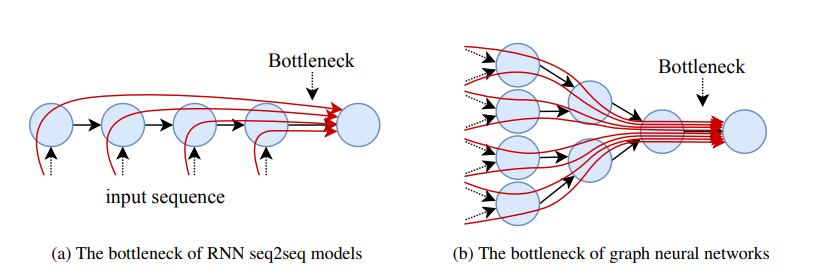


<em> Figure 3: Illustration of the oversquashing phenomenon in RNNs (left) and GNNs (right). Source: [(Alon et al., 2021)](https://arxiv.org/pdf/2006.05205)</em>

### Quantifying Oversquashing

[(Topping et al., 2022)](https://arxiv.org/pdf/2111.14522) introduced the following oversquashing upper bound:


<blockquote>

**Message passing neural networks (MPNNs).** Assume that the graph $G$ is equipped with node features $X \in \mathbb{R}^{n \times p_0}$ where $x_i \in \mathbb{R}^{p_0}$ is the feature vector at node $i=1, \ldots, n=|V|$. We denote by $h_i^{(\ell)} \in \mathbb{R}^{p_{\ell}}$ the representation of node $i$ at layer $\ell \geq 0$, with $h_i^{(0)}=x_i$. Given a family of message functions $\psi_{\ell}: \mathbb{R}^{p_{\ell}} \times \mathbb{R}^{p_{\ell}} \rightarrow \mathbb{R}^{p_{\ell}^{\prime}}$ and update functions $\phi_{\ell}: \mathbb{R}^{p_{\ell}} \times \mathbb{R}^{p_{\ell}^{\prime}} \rightarrow \mathbb{R}^{p_{\ell+1}}$, we can write the $(\ell+1)$-st layer output of a generic MPNN as follows (Gilmer et al., 2017):
$$
h_i^{(\ell+1)}=\phi_{\ell}\left(h_i^{(\ell)}, \sum_{j=1}^n \hat{A}_{i j} \psi_{\ell}\left(h_i^{(\ell)}, h_j^{(\ell)}\right)\right) \;\;\;(1)
$$

Here we have used the augmented normalized adjacency matrix to propagate messages from each node to its neighbors, which simply leads to a degree normalization of the message functions $\psi_{\ell}$.

**Sensitivity analysis.** The hidden feature $h_i^{(\ell)}=h_i^{(\ell)}\left(x_1, \ldots, x_n\right)$ computed by an MPNN with $\ell$ layers as in equation 1 is a differentiable function of the input node features $\left\{x_1, \ldots, x_n\right\}$ as long as the update and message functions $\phi_{\ell}$ and $\psi_{\ell}$ are differentiable. The over-squashing of information can then be understood in terms of one node representation $h_i^{(\ell)}$ failing to be affected by some input feature $x_s$ of node $s$ at distance $r$ from node $i$. Hence, we propose the $J_{a c o b i a n} \partial h_i^{(r)} / \partial x_s$ as an explicit and formal way of assessing the over-squashing effect.

**Lemma 1.** Assume an MPNN as in equation 1. Let $i, s \in V$ with $s \in S_{r+1}(i)$. If $\left|\nabla \phi_{\ell}\right| \leq \alpha$ and $\left|\nabla \psi_{\ell}\right| \leq \beta$ for $0 \leq \ell \leq r$, then
$$
\left|\frac{\partial h_i^{(r+1)}}{\partial x_s}\right| \leq(\alpha \beta)^{r+1}\left(\hat{A}^{r+1}\right)_{i s}
$$
</blockquote>

Note that $S_{r+1}(i)$ is the union of the multi-hop neighborhoods of $i$ up to radius $r+1$.

**📝TODO** Derive this Lemma step-by-step:
1. First describe $\hat{A} = D^{-1}A$ from a probabilistic point of view -- what does the entry $i,j$ tell you?.
2. Extend part 1 to deduce the meaning and the general form of $\hat{A}^r$ $\forall r \geq 0$ (hint: think of paths from $i,j$ of length $r$).
3. Compute the bound for a single layer and show that base case ($r=0$) is true.
4. Finish the proof by induction.

**Hint:** For steps 1-2, Think element-wise.